In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skorch import NeuralNetRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
%matplotlib inline

# Helper Functions

In [38]:
def add_noise(df, scale):
    noise = pd.DataFrame(np.random.normal(loc=0, scale=scale, size=df.shape), columns=df.columns)

    df_noisy = noise.add(df)

    return df_noisy

In [39]:
# determine the supported device
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu') # don't have GPU 
    return device

# convert a df to tensor
def df_to_tensor(df):
    device = get_device()
    return torch.from_numpy(df.values.astype(np.float32)).to(device)

# Prepare Data

In [40]:
# read data
spectrum_train = pd.read_excel('spectrum_train.xlsx')
spectrum_test = pd.read_excel('spectrum_valid.xlsx')
temp_train = pd.read_excel('temp_train.xlsx')
temp_test = pd.read_excel('temp_valid.xlsx')

In [41]:
# scale spectrum data
data_scale = 10**12
spectrum_train = spectrum_train.multiply(data_scale)
spectrum_test = spectrum_test.multiply(data_scale)

In [42]:
from sklearn.model_selection import train_test_split
# set train and test data

# 1 - temp to spectrum
# 0 - spectrum to temp
direction = 1

# use only if split == 1
# 1 - combine given training and validation data
# 0 - use only training data
combine = 0

# 1 - noise added to training data
# 0 - no noise added
noise_scale = 0.01
noise = 1

if noise:
    if direction:
        temp_train = add_noise(temp_train, noise_scale)
    else:
        spectrum_train = add_noise(spectrum_train, noise_scale)

if not combine:
    if direction:
        X_train = temp_train
        X_test = temp_test
        y_train = spectrum_train
        y_test = spectrum_test
    else:
        X_train = spectrum_train
        X_test = spectrum_test
        y_train = temp_train
        y_test = temp_test
else:
    spectrum = pd.concat([spectrum_train, spectrum_test], axis=0)
    temp = pd.concat([temp_train, temp_test], axis=0)
    if direction:
        X_train, X_test, y_train, y_test = train_test_split(temp, spectrum, test_size=0.3, random_state=101)
    else:
        X_train, X_test, y_train, y_test = train_test_split(spectrum, temp, test_size=0.3, random_state=101)

In [43]:
# create input and output tensors
X = df_to_tensor(X_train)
y = df_to_tensor(y_train)

In [44]:
n_samples, input_size = X.shape
_, output_size = y.shape

In [45]:
input_size

11

# Design Model 
(input size, output size, forward pass)

In [46]:
class Net(nn.Module):
    def __init__(self, input_size, output_size, hidden_units, num_layers):
        super(Net, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_units = hidden_units
        self.num_layers = num_layers
        
        self.hidden_layers = nn.ModuleList()
        
        # Create the hidden layers
        for _ in range(self.num_layers):
            self.hidden_layers.append(nn.Linear(self.input_size, self.hidden_units))
            self.input_size = self.hidden_units
            
        # Output layer
        self.output_layer = nn.Linear(self.input_size, self.output_size)
        
    def forward(self, x):
        for layer in self.hidden_layers:
            x = layer(x)
        output = self.output_layer(x)
        return output


In [47]:
model = NeuralNetRegressor(
    module=Net,
    module__input_size = input_size,
    module__output_size = output_size,
    criterion = nn.MSELoss,
    max_epochs = 1000,
    optimizer = torch.optim.Rprop,
    verbose = 1
)

param_grid = {
    'module__hidden_units': [30, 45, 60],
    'optimizer__lr': [0.001, 0.01, 0.1],
    'module__num_layers': [2, 8, 16, 32],
}

grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error')

# Training Loop

In [48]:
grid_search.fit(X, y)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1      612.9345       22.1611  0.0306
      2       10.6388        3.9431  0.0275
      3        2.3369        1.0095  0.0285
      4        0.7005        0.4829  0.0407
      5        0.4465        0.3999  0.0344
      6        0.3952        0.3673  0.0272
      7        0.3704        0.3480  0.0264
      8        0.3534        0.3352  0.0257
      9        0.3414        0.3244  0.0281
     10        0.3306        0.3148  0.0263
     11        0.3212        0.3068  0.0260
     12        0.3130        0.2988  0.0256
     13        0.3057        0.2922  0.0248
     14        0.2993        0.2869  0.0246
     15        0.2944        0.2830  0.0273
     16        0.2905        0.2796  0.0252
     17        0.2875        0.2772  0.0258
     18        0.2852        0.2751  0.0252
     19        0.2833        0.2733  0.0247
     20        0.2816        0.2720  0.0272
     21        0.2804        0.2

In [ ]:
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

In [ ]:
best_params

{'module__hidden_units': 60,
 'module__num_layers': 8,
 'optimizer': torch.optim.adam.Adam,
 'optimizer__lr': 0.001}

In [ ]:
pred = pd.DataFrame(best_model.predict(df_to_tensor(X_test)))
mse = mean_squared_error(y_test, pred)
print(f'Mean Squared Error of the Best Model: {mse}')

Mean Squared Error of the Best Model: 0.06042432417046516


# Plots

### Clean

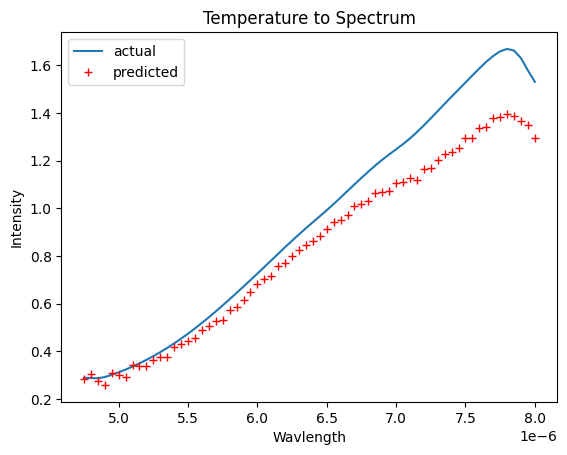

In [ ]:
import matplotlib.pyplot as plt
import random

index = random.randint(0, len(pred))

actual_np = y_train.values[index]
pred_np = pred.values[index]


plt.plot(y_train.columns, actual_np, label='actual')
plt.plot(y_train.columns, pred_np, 'r+', label='predicted')

if direction:
    plt.title("Temperature to Spectrum")
    plt.xlabel("Wavlength")
    plt.ylabel("Intensity")
else:
    plt.title("Spectrum to Temperature")
    plt.xlabel("Layer")
    plt.ylabel("Temperature (K)")

plt.legend()
plt.show()

### Noisy

In [ ]:
noisy_test = add_noise(X_test, 0.01)

pred = pd.DataFrame(best_model.predict(df_to_tensor(noisy_test)))

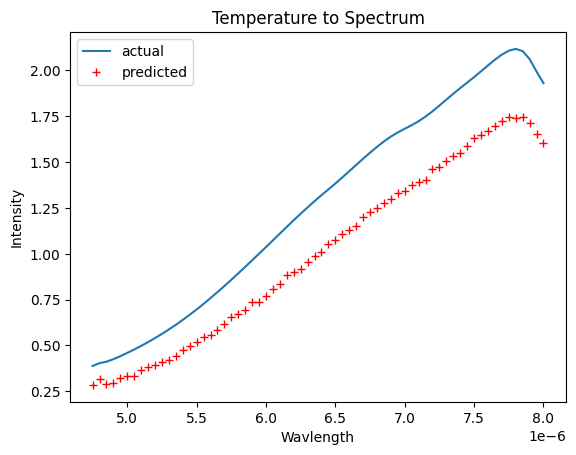

In [ ]:
import matplotlib.pyplot as plt
import random

index = random.randint(0, len(pred))

actual_np = y_test.values[index]
pred_np = pred.values[index]


plt.plot(y_train.columns, actual_np, label='actual')
plt.plot(y_train.columns, pred_np, 'r+', label='predicted')

if direction:
    plt.title("Temperature to Spectrum")
    plt.xlabel("Wavlength")
    plt.ylabel("Intensity")
else:
    plt.title("Spectrum to Temperature")
    plt.xlabel("Layer")
    plt.ylabel("Temperature (K)")

plt.legend()
plt.show()